In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
except:
    os.chdir('Modules')
# from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

# Ganerate Spike from FBFF model (Poison)

## k_E and k_S

In [29]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [30]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404

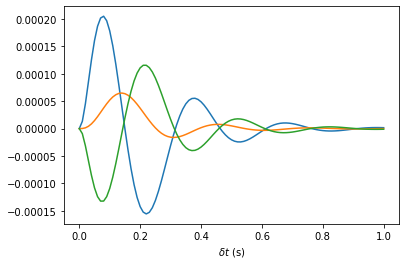

In [31]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.xlabel(r'$\delta t$ (s)')
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

## Load and Check Input

In [32]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=10_C=0.2_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

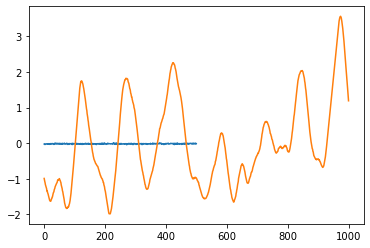

In [33]:
restTime = 5
stiTime = 10
trial = 1000

plt.plot(x[:int(restTime/dt)])
plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

xOri = x.copy()
x = x[int(restTime/dt):int((restTime+stiTime)/dt)]

In [34]:
amp = 2
mean = 10

psi = 0.3

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(x)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,x*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(x)]
output = -(eOutput*(1-psi)-sOutput*psi)

## Subtraction + GC (Gain act on both)

In [35]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [36]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 245.0 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

Mean = 10
Contrast = 0.2
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean,(x*Contrast+1)*Mean)), k_E, 'full')[:apapt_step+len(x)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*Mean,(x*Contrast+1)*Mean)), k_S, 'full')[:apapt_step+len(x)]
eOutput, _ = AddGainControl(eOutput, B_e, tau_e)    
sOutput, _ = AddGainControl(sOutput, B_s, tau_s)

output = -eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi

## spike generation

In [37]:
r = output
Spike_Trial = [0]*trial
for ti in range(trial):
    Spike_Trial[ti] = Spike_Time_Generater( NL(r,np.mean(r)), dt, 10, 10)

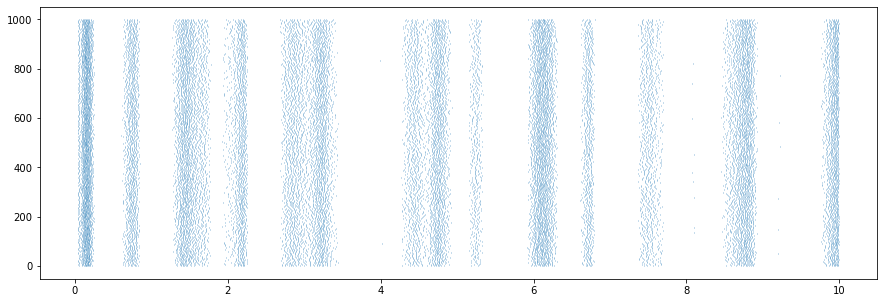

In [38]:
fig, ax = plt.subplots()
ax.eventplot(Spike_Trial, linewidths=0.5)
fig.set_size_inches(15, 5)

# varify Poison with variance-mean (Fano factor)

Text(0.5, 1.0, 'stimulus: LPOU')

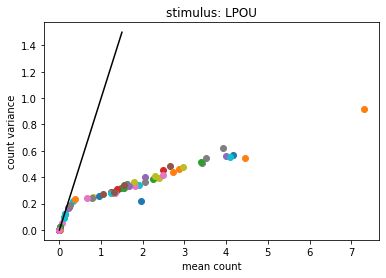

In [40]:
winSize = 0.1 # dt = 0.01

rstate_Trial = [0]*trial
for ti in range(trial):
    rstate_Trial[ti], _ = np.histogram(Spike_Trial[ti], np.arange(int(stiTime/winSize)+1)*winSize)
for i in range(len(rstate_Trial[ti])):
    plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))

plt.plot([0, 15*winSize], [0, 15*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')

Text(0.5, 1.0, 'stimulus: LPOU')

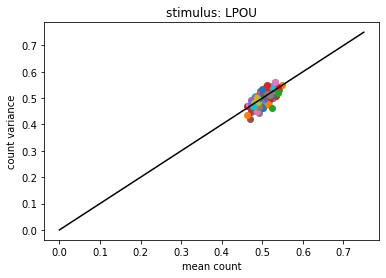

In [44]:
winSize = 0.05# dt = 0.01
firingRate = 10
Gamma = 1
trial = 1000
rstate_Trial = [0]*trial
for ti in range(trial):
    rstate_Trial[ti], _ = np.histogram(  Spike_Time_Generater( np.ones(int(restTime*2/dt)), dt, firingRate, Gamma)  , np.arange(int(restTime/winSize)+1)*winSize)
for i in range(len(rstate_Trial[ti])):
    plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))
plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()), s = 50, marker = 'x')

plt.plot([0, 15*winSize], [0, 15*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulus: LPOU')